## Regressão de Poisson




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

df = pd.read_csv('crime.csv', delimiter=" ")
df.head()

,stops,pop,past.arrests,precinct,eth,crime
0,75,1720,191,1,1,1
1,36,1720,57,1,1,2
2,74,1720,599,1,1,3
3,17,1720,133,1,1,4
4,37,1368,62,1,2,1


Os dados consistem em dados de parada e revista

- paradas : O número de paradas policiais entre janeiro de 1998 e março de 1999, para cada combinação de distrito, etnia e tipo de crime.
- pop : A população.
- past.arrests : O número de prisões ocorridas em 1997 para cada combinação de distrito, etnia e tipo de crime.
- distrito : Índice do distrito (1-75).
- eth : Indicador de etnia, negro (1), hispânico (2), branco (3). Outros grupos étnicos foram excluídos porque ambiguidades na - classificação causariam grandes distorções na análise 2 .
- crime : Indicador para o tipo, violento (1), armas (2), bens (3), drogas (4).

## Formatação dos dados

In [2]:
X = (df
    .groupby(['eth', 'precinct'])[["stops", "past.arrests"]]
    .sum()
    .reset_index()
    .pipe(pd.get_dummies, columns=['eth', 'precinct'])
    .assign(intercept=1)  # Adds a column called 'intercept' with all values equal to 1.
    .sort_values(by='stops')
    .reset_index(drop=True)
)

y = X.pop("stops")

Neste caso tranformamos nossas variáveis em TRUE or FALSE. Para etina e Distrito

In [3]:
X

,past.arrests,eth_1,eth_2,eth_3,precinct_1,precinct_2,precinct_3,precinct_4,precinct_5,precinct_6,...,precinct_67,precinct_68,precinct_69,precinct_70,precinct_71,precinct_72,precinct_73,precinct_74,precinct_75,intercept
0,16,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,1
1,97,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
2,338,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3,115,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
4,44,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2166,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,1
221,3468,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,1
222,4209,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
223,4540,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1


In [4]:
y

0         7
1         7
2         9
3        11
4        11
       ... 
220    2467
221    2492
222    2500
223    2705
224    2771
Name: stops, Length: 225, dtype: int64

### Ajustando o Modelo nulo -> sem preditores

In [5]:
model_no_indicators = sm.GLM(
    y,
    X["intercept"],
    offset=np.log(X["past.arrests"]),
    family=sm.families.Poisson(),
)
result_no_indicators = model_no_indicators.fit()
print(result_no_indicators.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  stops   No. Observations:                  225
Model:                            GLM   Df Residuals:                      224
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23913.
Date:                Mon, 10 Mar 2025   Deviance:                       46120.
Time:                        19:01:11   Pearson chi2:                 4.96e+04
No. Iterations:                     5   Pseudo R-squ. (CS):         -3.242e-14
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.5877      0.003   -213.058      0.0

O que devemos avaliar:
    
    - coefe 
    - std err 
    - Deviance
    - z e p-valor (teste de Wald)
    

O erro padrão ajuda a diagnosticar se o coeficiente encontrado é estatisticamente significativo ou não. 

O desvio é uma medida de erro, então quanto menor, melhor. 

Assim, ao adicionar parâmetros ao seu modelo, você deseja garantir que o desvio diminua em mais de 1 unidade por parâmetro adicionado.

Analise gráfica:  Valores observados x valores ajustados. Os valores ajustados são convenientemente armazenados no fittedvalues atributo do resultado.

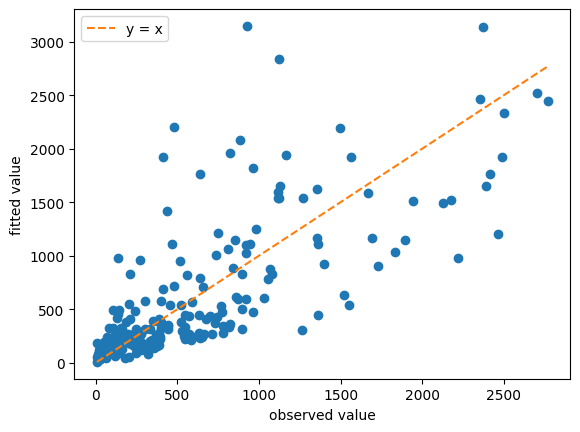

In [6]:
plt.plot(y, result_no_indicators.fittedvalues, 'o')
plt.plot(y, y, '--', label='y = x')
plt.ylabel("fitted value")
plt.xlabel("observed value")
plt.legend()
plt.show()

### Adicionando as variáveis de Etnia

Baseamo-nos no modelo anterior, adicionamos os indicadores de etnia. 

Observe que não adicionamos o indicador de etnia para negros (1) porque o usamos como referência.

In [7]:
# Convertendo os tipos de dados, se necessário
X = X.astype(float)
y = y.astype(float)

In [8]:
model_with_ethnicity = sm.GLM(
    y,
    X[['intercept', 'eth_2', 'eth_3']],
    offset=np.log(X["past.arrests"]),
    family=sm.families.Poisson(),
)
result_with_ethnicity = model_with_ethnicity.fit()
print(result_with_ethnicity.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  stops   No. Observations:                  225
Model:                            GLM   Df Residuals:                      222
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23572.
Date:                Mon, 10 Mar 2025   Deviance:                       45437.
Time:                        19:01:12   Pearson chi2:                 4.94e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9519
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.5881      0.004   -155.396      0.0

A adição dos dois indicadores de etnia como preditores diminuiu o desvio em 683 unidades. 


### Adicionandoos indicadores de distrito

Baseamo-nos no modelo anterior, adicionando primeiro os indicadores de etnia. 

Observe que não adicionamos o indicador de etnia para negros (1) porque o usamos como referência.

In [9]:
model_Poisson = sm.GLM(
    y,
    X.drop(columns=["eth_1", "precinct_1", "past.arrests"]),
    offset=np.log(X["past.arrests"]),
    family=sm.families.Poisson(),
)

result_model_Poisson = model_Poisson.fit()
print(result_model_Poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  stops   No. Observations:                  225
Model:                            GLM   Df Residuals:                      148
Model Family:                 Poisson   Df Model:                           76
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2566.9
Date:                Mon, 10 Mar 2025   Deviance:                       3427.1
Time:                        19:01:12   Pearson chi2:                 3.24e+03
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
eth_2           0.0102      0.007      1.498      

Diminuição no desvio – os fatores do distrito definitivamente não são ruído. 

Com tantos distritos, talvez seja mais fácil ver a exponencial dos coeficientes estimados em um gráfico.

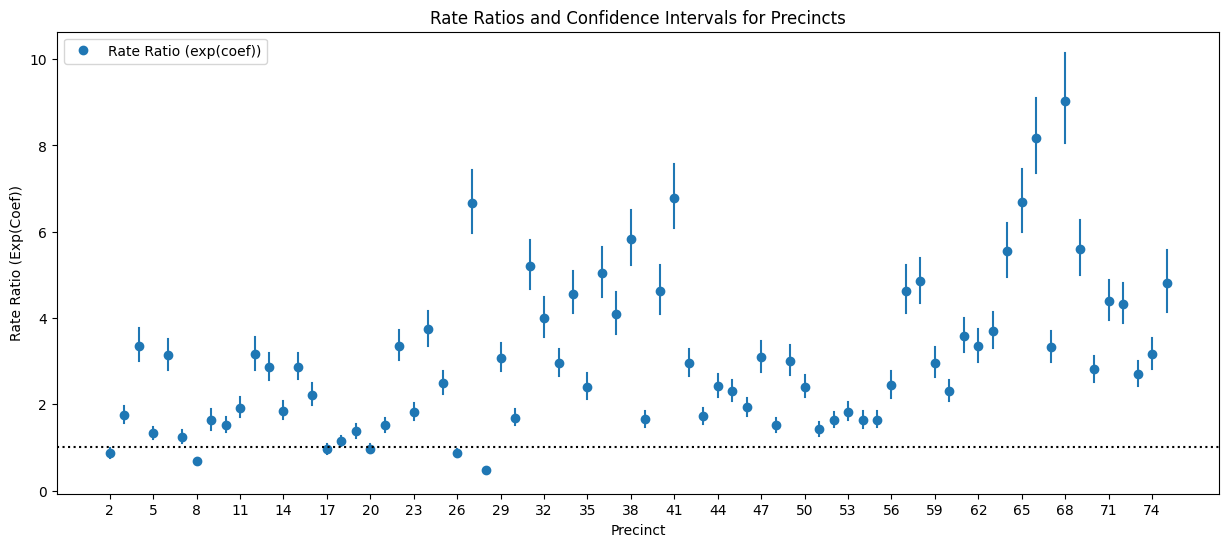

In [10]:
# Coeficientes dos precincts
precinct_coefs = result_model_Poisson.params.iloc[2:-1]  # Apenas os coeficientes dos precincts
precinct_interval = result_model_Poisson.conf_int().reindex(precinct_coefs.index)

# Transformação exponencial (para exibir razões de taxas)
exp_precinct_coefs = np.exp(precinct_coefs)
exp_precinct_interval = np.exp(precinct_interval)

# Criando o gráfico
plt.figure(figsize=(15, 6))
plt.plot(exp_precinct_coefs, 'o', label="Rate Ratio (exp(coef))", color='C0')

# Adicionando intervalos de confiança
for precinct, interval in exp_precinct_interval.iterrows():
    plt.plot([precinct, precinct], interval, color='C0')

# Linha de referência em 1 (onde não há efeito)
plt.axhline(y=1, linestyle=':', color='black')

# Ajustando os rótulos do eixo X
plt.xticks(
    precinct_coefs.index[::3],
    [int(x[1]) for x in precinct_coefs.index.str.split("_",)][::3]
)

# Rótulos e título
plt.ylabel("Rate Ratio (Exp(Coef))")
plt.xlabel("Precinct")
plt.title("Rate Ratios and Confidence Intervals for Precincts")
plt.legend()
plt.show()

## Superdispersão

A distribuição de Poisson não possui parâmetros independentes para a variância como, digamos, uma distribuição normal. 

Acontece que para a distribuição de Poisson:  variância é igual à média.

Isso significa que você pode avaliar facilmente se seus dados são Poisson ou não. 
Os resíduos do ajuste devem ter média igual a zero. 

Podemos ir um pouco mais longe e observar os resíduos padronizados que não só deve ter média zero, mas também desvio padrão igual a 1

O resultado dos modelos armazena convenientemente os valores dos resíduos e resíduos padronizados:
    
    - resid_response  
    - resid_pearson;

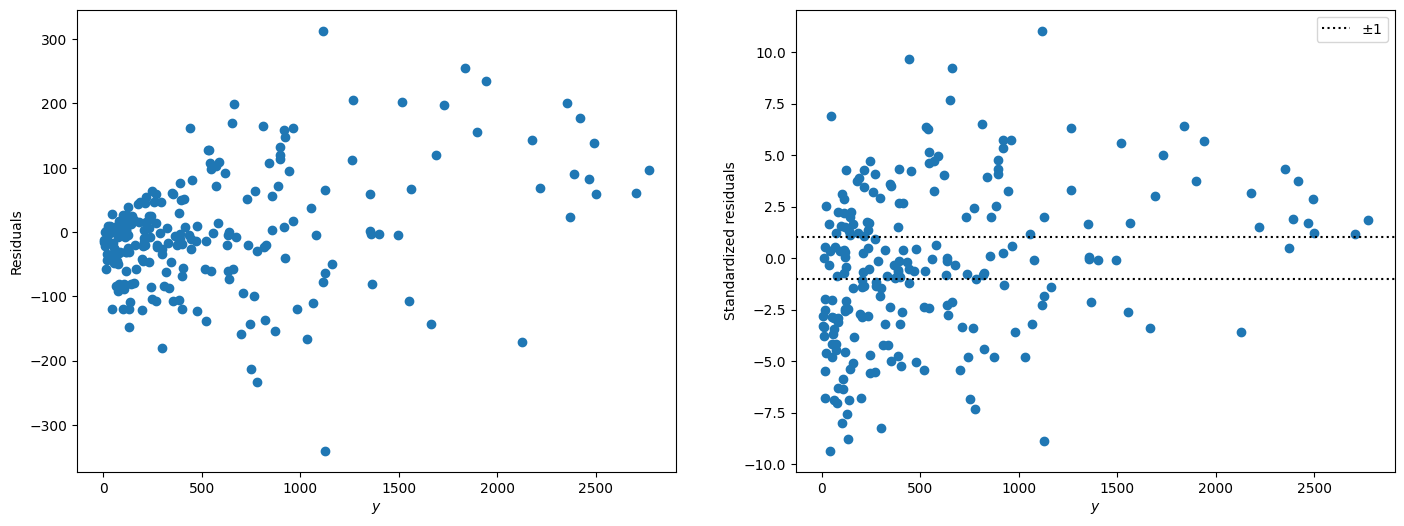

In [11]:
f, axes = plt.subplots(1, 2, figsize=(17, 6))
axes[0].plot(y, result_model_Poisson.resid_response, 'o')
axes[0].set_ylabel("Residuals")
axes[0].set_xlabel("$y$")
axes[1].plot(y, result_model_Poisson.resid_pearson, 'o')
axes[1].axhline(y=-1, linestyle=':', color='black', label='$\pm 1$')
axes[1].axhline(y=+1, linestyle=':', color='black')
axes[1].set_ylabel("Standardized residuals")
axes[1].set_xlabel("$y$")
plt.legend()
plt.show()

No gráfico da esquerda, vemos que a variância aumenta com os valores ajustados – como esperado de uma distribuição de Poisson. 

Mas se os dados fossem bem descritos pelo nosso modelo de Poisson, 95% dos resíduos padronizados deveriam estar dentro de 2 desvios padrão. 


Se os dados fossem de Poisson, a soma dos quadrados dos resíduos padronizados seguiria uma distribuição qui-quadrado comn - k
graus de liberdade, então esperaríamosa taxa de dispersão = 1

**Quando taxa de superdispersão > 0**

dizemos que os dados estão superdispersos porque há variação extra nos dados que não é capturada pelo modelo de Poisson. 

**Quando  taxa de superdispersão < 1**

dizemos que os dados estão pouco dispersos

In [12]:
taxa_superdispersão = result_model_Poisson.pearson_chi2 / result_model_Poisson.df_resid
taxa_superdispersão

21.885050984204934

Ok, então como explicamos a superdispersão? 

Precisaremos de um parâmetro extra em nosso modelo (assim como uma distribuição normal tem um parâmetro para a média e outro para a variância). 

Faremos entao utilizando a distribuição binomial negativa em vez de Poisson.


O parâmetro alfa é o que nos ajuda a especificar a quantidade de superdispersão. 

Então simplesmente ajustamos um modelo binomial negativo com um pouco de superdispersão

In [13]:
alpha = 0.05

# como estimar no alpha?
model_NB = sm.GLM(
    y,
    X.drop(columns=["eth_1", "precinct_1", "past.arrests"]),
    offset=np.log(X["past.arrests"]),
    family=sm.families.NegativeBinomial(alpha=alpha),
)

result_NB = model_NB.fit()
print(result_NB.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  stops   No. Observations:                  225
Model:                            GLM   Df Residuals:                      148
Model Family:        NegativeBinomial   Df Model:                           76
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1301.7
Date:                Mon, 10 Mar 2025   Deviance:                       247.09
Time:                        19:01:12   Pearson chi2:                     235.
No. Iterations:                     9   Pseudo R-squ. (CS):             0.9993
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
eth_2           0.0087      0.038      0.230      

In [14]:
# Ajustando um modelo de Poisson para obter um ponto de partida
model_Poisson = sm.GLM(y, X.drop(columns=["eth_1", "precinct_1", "past.arrests"]),
                       offset=np.log(X["past.arrests"]),
                       family=sm.families.Poisson()).fit()

# Obtendo os valores preditos do modelo de Poisson
mi = model_Poisson.fittedvalues

# Estimando alpha (método dos momentos)
residuals = (y - mi) ** 2 - mi  # Resíduos ajustados -> variancia empirica - a variancia encontrada em poisson
alpha_hat = np.sum(residuals / mi**2) / (len(y) - X.shape[1])  # Estimativa do alpha 

# Ajustando o modelo de Binomial Negativa com alpha estimado
model_NB = sm.GLM(y, 
                  X.drop(columns=["eth_1", "precinct_1", "past.arrests"]),
                  offset=np.log(X["past.arrests"]),
                  family=sm.families.NegativeBinomial(alpha=alpha_hat)).fit()

print(model_NB.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  stops   No. Observations:                  225
Model:                            GLM   Df Residuals:                      148
Model Family:        NegativeBinomial   Df Model:                           76
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1321.0
Date:                Mon, 10 Mar 2025   Deviance:                       128.92
Time:                        19:01:13   Pearson chi2:                     123.
No. Iterations:                    10   Pseudo R-squ. (CS):             0.9727
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
eth_2           0.0062      0.054      0.116      

Depois de contabilizar a sobredispersão, os erros padrão dos nossos coeficientes aumentam, por isso é importante verificar quais coeficientes permanecem significativos. 

Observe que o deviance é calculado de forma diferente para o modelo binomial negativo, portanto não tente comparar o deviance deste modelo com o anterior.

Fazer grafico de residuos

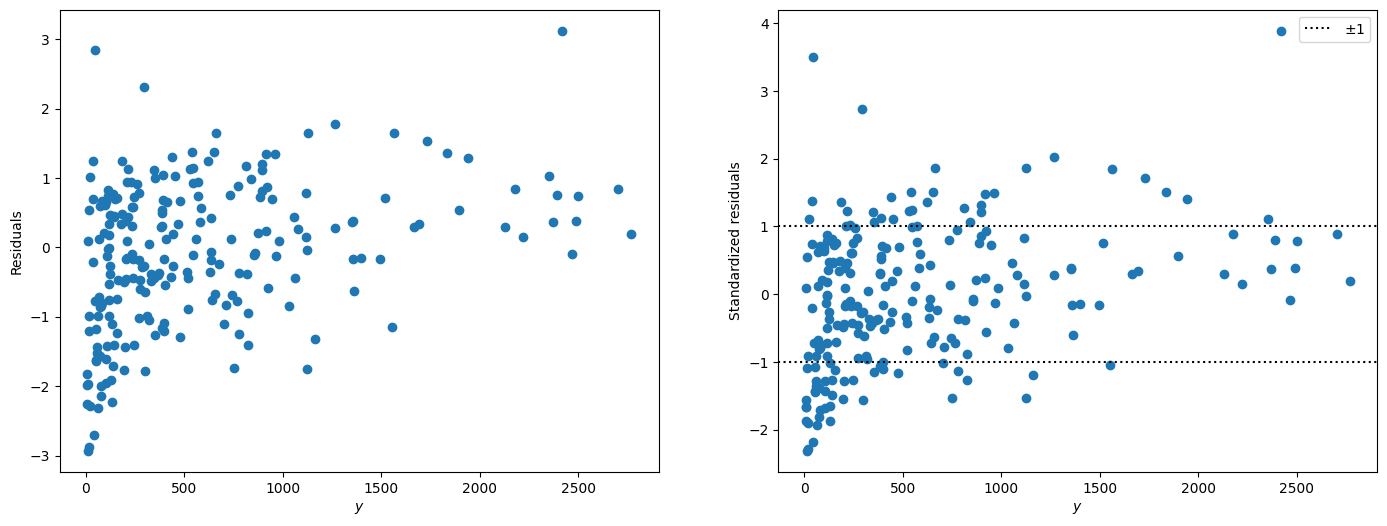

In [15]:
f, axes = plt.subplots(1, 2, figsize=(17, 6))
axes[0].plot(y, result_NB.resid_deviance, 'o')
axes[0].set_ylabel("Residuals")
axes[0].set_xlabel("$y$")
axes[1].plot(y, result_NB.resid_pearson, 'o')
axes[1].axhline(y=-1, linestyle=':', color='black', label='$\pm 1$')
axes[1].axhline(y=+1, linestyle=':', color='black')
axes[1].set_ylabel("Standardized residuals")
axes[1].set_xlabel("$y$")
plt.legend()
plt.show()

In [16]:
result_NB.resid_deviance

0     -1.823859
1     -1.977309
2     -2.257465
3     -1.964077
4      0.085331
         ...   
220   -0.089431
221    0.380624
222    0.745380
223    0.839645
224    0.194085
Length: 225, dtype: float64

**Exercício - faça os testes de hipóteses para validar o modelo.**